# LendingClub Data Analysis - Lab 1

Brady Arendale, Aaron Cattley, John Partee

# Business Understanding
LendingClub is a company which allows consumers to underwrite loans, investing with as little as $25 per loan, which can vary in interest rate, based on the risk associated with the loan. To clarify, this allows consumers to back other consumer's loans, accepting risk, but making (most of) the interest a bank would normally make if it is repaid. The data we are analyzing is collected when consumers apply for loans, to better inform potential investors on the risks associated with the loan. 

LendingClub grades loans and assigns interest rates based on the factors in this dataset. With that said, there may be some room to maximize our profitability if we are able to model loan defaults, and invest primarily in loans that LengingClub views as riskier, which are still highly likely not to default. We are looking to model risk, so that we can assume less risk, while maximizing the reward.

Our goal is to predict when a loan will or will not default. **This is a classification problem!** As we said above, if we can invest primarily in higher interest (thus, possibly riskier) loans which will be repaid, we can maximize our profit. We are particularly focused on minimizing false negatives (loans that default predicted to not default) since these are the cases that can cost us money. Therefore, we will use recall as our evaluation metric. We are concerned with how useful the results are in this case, more so than how complete. Overall accuracy is less important as there are still a huge number of loans to invest in, with limited capital. Even if we miss out on a few high interest loans that we misclassify, it is better to slightly lower our profit than to lose our whole investment into a loan. To train our model we will use ten-fold cross validation, and to test our model we will use a hold-out test set.


In [1]:
#setup block
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio
pio.renderers.default = 'notebook'

In [2]:
#Read the data in
df = pd.read_csv('LoanStats_securev1_2019Q2.csv')

F:\brady\Anaconda3\envs\ML7331\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning:

Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.



# Data Understanding

The data, obtained from LendingClub's website, is all of the loans that were fully funded in the second quarter of 2019. As this is a predictive problem, we chose to only focus on the statistics that we would have before the loan was issued. The original data is 131,141 rows of 150 columns, which we reduced to these 22 chosen attributes by the conditions we set for our classification problem. We also opted to only consider individual loan applicants, which allowed us to further reduce the dimensions of the data. Finally, through our EDA we found additional reason to remove 4 other variables.  This downselection left us with 20 columns (19 explanatory variables), and 111,863 rows. 

## Data definitions

- **loan_amnt** is the requested (and funded) amount of the loan in US dollars as a float. Note that these are all funded loans. 
- **term** is the length of the loan, 36 or 60 months. This is categorical object intentionally as it is not continuous.
- **int_rate** is the interest rate of the loan as a float.
- **sub_grade** is the letter 'grade' of the loan, with an additional numerical sub grade. This is a proxy for assessed risk, and is directly related to the interest rate. This is a categorical object.
- **purpose** is the categorical stated purpose of the loan applied for, as an object. 
- **emp_length** is the length of time in years the applicant has been at their current job. 0 represents someone who is unemployed. This is an integer.
- **home_ownership** describes whether an applicant owns, rents, or mortgages their home. This is a categorical object.
- **annual_inc** is the applicant's pre-tax annual income in US dollars, as a float.
- **verification_status** indicates whether LendingClub has verified the applicant's annual income, as a categorical object.
- **addr_state** is the state in which the applicant lives, as a categorical object.
- **dti** is the applicant's debt to income ratio, if the loan is granted, as a float.
- **earliest_cr_line** is the number of months from June 2019 from when the applicant's first line of credit was extended, as an integer.
- **fico_range_low** is the low end of the FICO score when credit was pulled, as a float.
- **inq_last_6mths** is the number of credit inquiries in the applicant's credit report in the last six months, as an integer.
- **open_acc** is the number of credit accounts the applicant has open, both revolving and installment, as an integer.
- **pub_rec** is the number of adverse public records against an applicant (Tax liens, judgements, collections), as an integer.
- **revol_bal** is the applicant's revolving debt balance (credit card debt), as a float.
- **loan_status** indicates the status of the loan, which has been generalized to either "Late or Unpaid" and "Current or Fully Paid", as a categorical object.



In [3]:
#As 150 variables is a little more than we want or need, we pared it down to these 20 variables, with loan_status as the response:
df = df[['loan_amnt', 'term', 'int_rate',
          'sub_grade', 'purpose', 'emp_length',
          'home_ownership', 'annual_inc',
          'verification_status', 'addr_state', 'dti',
          'earliest_cr_line', 'fico_range_low', 'inq_last_6mths',
          'open_acc', 'pub_rec', 'revol_bal',
          'application_type', 'loan_status']]

#narrow it down to single applications, not joint, and drop application type
df = df.loc[df['application_type'] == 'Individual']
df = df.drop(columns = ['application_type'])

#make the emp_length numerical
df['emp_length'] = df['emp_length'].fillna('0').str.extract('(\d+)').astype(int)

#Make int_rate numerical
df['int_rate'] = df['int_rate'].str.extract('(\d+)').astype(float)

#Make inq_last_6mths an integer
df['inq_last_6mths'] = df['inq_last_6mths'].astype(int)

#Make open_acc an integer
df['open_acc'] = df['open_acc'].astype(int)

#Make pub_rec an integer
df['pub_rec'] = df['pub_rec'].astype(int)

#Some light feature engineering for earliest_cr_line, which is not a factor, but a descrete variable. 
from datetime import datetime
def timeFromJun19(date):
  date = datetime.strptime(date, '%b-%Y')
  return (2019 - date.year)*12 + 6 - date.month

df['earliest_cr_line'] = df['earliest_cr_line'].apply(timeFromJun19)

#Lastly, we're going to consolidate the 'good' and 'bad' loan labels into two groups- We want to get paid,
#so the degree of lateness is irrelevant! 
df = df.replace(['Charged Off', 'Late (16-30 days)', 'Late (31-120 days)', 'In Grace Period'],
                "Late or Unpaid")
df = df.replace(['Current', 'Fully Paid'],
                'Current or Fully Paid')

#Roll up sub grade to simplify dummy variables
df['letter_grade'] = [i[0] for i in df['sub_grade']]

#Remove sub grade
del df['sub_grade']

The output below shows the encoding of the 17 variables, and the response.

In [4]:
df.info()
print("\nDuplicated records: ")
df.duplicated().value_counts()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 111863 entries, 0 to 131138
Data columns (total 18 columns):
loan_amnt              111863 non-null float64
term                   111863 non-null object
int_rate               111863 non-null float64
purpose                111863 non-null object
emp_length             111863 non-null int64
home_ownership         111863 non-null object
annual_inc             111863 non-null float64
verification_status    111863 non-null object
addr_state             111863 non-null object
dti                    111863 non-null float64
earliest_cr_line       111863 non-null int64
fico_range_low         111863 non-null float64
inq_last_6mths         111863 non-null int64
open_acc               111863 non-null int64
pub_rec                111863 non-null int64
revol_bal              111863 non-null float64
loan_status            111863 non-null object
letter_grade           111863 non-null object
dtypes: float64(6), int64(5), object(7)
memory usage: 16.2+ 

False    111863
dtype: int64

## Data Quality	
**NA values:**  
Here we've identified that the Employment Length has ~1000 NaNs.  As we delved further, we noticed that the entirety of the NA values also had no employer listed, therefore indicating they do not have work experience.  We set these values to zero. The previous code handles the NA's as described.
 
**Duplicate data:**
We found no duplicated records in this dataset.
    
**Outliers:**

We will examine a few graphs to see if there are any outliers in our dataset.

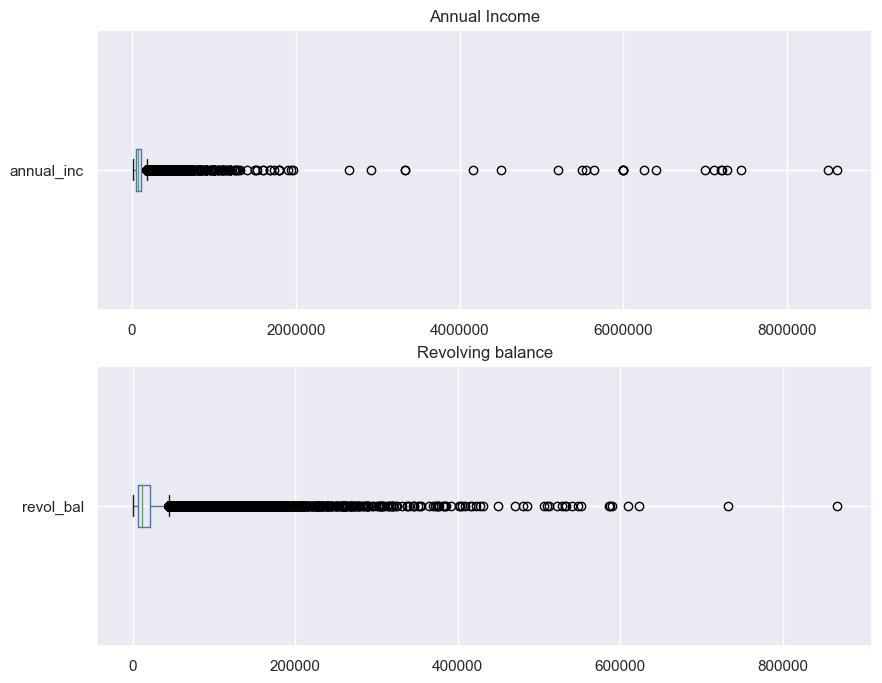

In [5]:
plt.style.use('default') # makes the size nice
sns.set()
fig, (ax0, ax1) = plt.subplots(2,1, figsize=(10,8))

#Annual income
df.annual_inc.plot(kind='box', vert=False, ax=ax0)
ax0.set_title('Annual Income')

#Revolving balance
df.revol_bal.plot(kind='box', vert=False, ax=ax1)
ax1.set_title('Revolving balance')
plt.show()

Our data contains outliers as shown in the above graphs for annual income and revolving balance. We believe these are valid data and not input errors or some other kind of mistake. We will account for these during modeling by standardizing all columns.

# Simple Statistics

### Summary statistics for all variables

In [6]:
df.describe()

loan_amnt       int_rate     emp_length    annual_inc  \
count  111863.000000  111863.000000  111863.000000  1.118630e+05   
mean    15867.522997      12.235681       5.180319  8.822018e+04   
std     10107.867565       4.843253       3.825286  1.089210e+05   
min      1000.000000       6.000000       0.000000  6.000000e+03   
25%      8075.000000       8.000000       1.000000  5.000000e+04   
50%     13000.000000      12.000000       5.000000  7.200000e+04   
75%     21275.000000      15.000000      10.000000  1.038580e+05   
max     40000.000000      30.000000      10.000000  8.608920e+06   

                 dti  earliest_cr_line  fico_range_low  inq_last_6mths  \
count  111863.000000     111863.000000    111863.00000   111863.000000   
mean       18.701632        194.445223       705.03102        0.432618   
std         8.712867         94.316113        33.94230        0.724139   
min         0.000000         37.000000       660.00000        0.000000   
25%        12.170000        135.000000       680.00000        0.000000   
50%        18.150000        176.000000       700.00000        0.000000   
75%        24.810000        239.000000       725.00000        1.000000   
max        39.990000        821.000000       845.00000        5.000000   

            open_acc        pub_rec      revol_bal  
count  111863.000000  111863.000000  111863.000000  
mean       12.001448       0.109920   17754.483699  
std         6.109479       0.318204   22759.575765  
min         0.000000       0.000000       0.000000  
25%         8.000000       0.000000    6242.000000  
50%        11.000000       0.000000   11974.000000  
75%        15.000000       0.000000   21635.000000  
max        93.000000       6.000000  866850.000000

### Income distribution compared to the total US

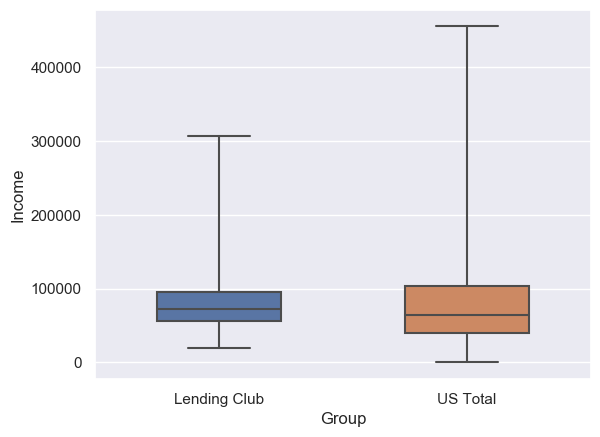

In [7]:
#Find quantiles for US income and dataframe
us_inc = [0,30001,61822,61822,111160,434455]
df_inc = df.quantile([.01,.25,.5,.5,.75,.99]).annual_inc

#Adjust 2017 numbers for inflation
us_inc = [x*1.0467 for x in us_inc]

#Combine lists and plot
inc_combined = pd.DataFrame({"Lending Club":df_inc, "US Total":us_inc}).melt()

sns.boxplot(x='variable', y='value', data=inc_combined, whis=1000, width=.5)
plt.xlabel('Group')
plt.ylabel('Income')
plt.show()

Sources: [US income distribution](https://dqydj.com/average-median-top-household-income-percentiles/), [inflation rate](http://www.in2013dollars.com/us/inflation/2017)

We compared the distribution of income of Lending Club applicants to that of the US as a whole. US income data is from 2017 and adjusted for inflation. Lending Club applicants appear to have a higher median income than the total US by about \\$7000, but the distribution is less spread out. The mean income for Lending Club applicants is about \\$2400 less than the national average due to the stronger right skew of the total US distribution.

### FICO score statistics

In [8]:
#Calculate cumulative quantiles for total US
quantiles = [4.3, 6.8, 7.8, 9.3, 12.5, 16.2, 20.7, 22.4]
quantiles = np.cumsum(quantiles)/100

#Calculate quantiles for dataframe
fico_cut = pd.cut(df.fico_range_low, [300,500,550,600,650,700,750,800,850])
fico_cut = fico_cut.value_counts()/len(df)
fico_cut = fico_cut[sorted(fico_cut.index)]

#Combine quantiles
fico_combined = pd.DataFrame({"Lending Club":np.cumsum(fico_cut), "US Total":quantiles})
fico_combined.index = ["300-500","500-550","550-600","600-650","650-700","700-750","750-800","800-850"]
print("Cumulative quantiles per score range:")
fico_combined.round(3)

Cumulative quantiles per score range:


Lending Club  US Total
300-500         0.000     0.043
500-550         0.000     0.111
550-600         0.000     0.189
600-650         0.000     0.282
650-700         0.543     0.407
700-750         0.897     0.569
750-800         0.989     0.776
800-850         1.000     1.000

[source](https://www.fico.com/blogs/average-u-s-fico-score-ticks-706)

The average FICO credit score among Lending Club applicants is 705, which lines up with the national average of 706. Lending Club applicants have higher FICO scores than the total US at each quantile.

### Other statistics of interest

In [9]:
df.purpose.value_counts(normalize=True)

debt_consolidation    0.541663
credit_card           0.270787
home_improvement      0.062425
other                 0.056659
major_purchase        0.017816
house                 0.010951
medical               0.010450
car                   0.008904
vacation              0.007688
small_business        0.006883
moving                0.005310
renewable_energy      0.000465
Name: purpose, dtype: float64

Over half of all loans are for debt consolidation, and credit card payments make up another quarter. Home improvement and other are the only other categories with more than 2% of loans. We may be particularly interested in determining how certain statistics affect whether debt consolidation or credit card loans become good or bad loans.

In [10]:
df.term.value_counts(normalize=True)

 36 months    0.696057
 60 months    0.303943
Name: term, dtype: float64

There are more than double the amount of 36 months loans than 60 months loans. 36 months loans offer us a quicker return on investment per dollar, so optimizing our model for these loans may be of interest in the future.

In [11]:
df.inq_last_6mths.describe()

count    111863.000000
mean          0.432618
std           0.724139
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           5.000000
Name: inq_last_6mths, dtype: float64

The vast majority of Lending Club applicants have had 0 or 1 credit inquiry in the last 6 months (excluding auto and mortgage inquiries). More inquiries may mean either more liabilities for the borrower to pay off or that they were rejected for credit multiple times. In either case, we may need to be cautious when investing in these loans.

# Visualize Attributes

We will examine some variables of interest to get an idea what our data looks like.

### Loan status

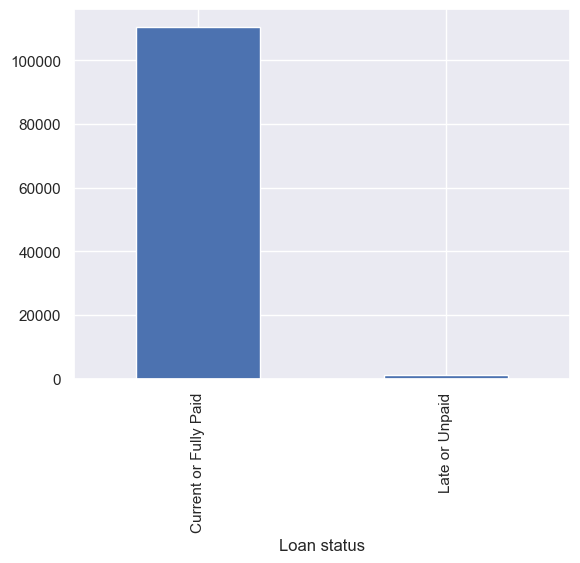

In [12]:
df.loan_status.value_counts().plot(kind='bar')
plt.xlabel('Loan status')
plt.show()

In [13]:
df.loan_status.value_counts(normalize=True)

Current or Fully Paid    0.987726
Late or Unpaid           0.012274
Name: loan_status, dtype: float64

The most important variable, of course, is whether a loan defaults or not. In this dataset, a very small percentage of loans are defaults, just over 1 percent.

### Loan amount

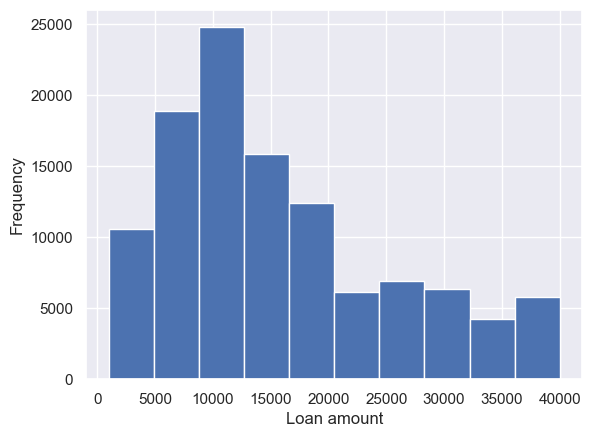

In [14]:
df.loan_amnt.plot(kind='hist')
plt.xlabel('Loan amount')
plt.show()

Loan amount is right skewed, with the most common values being between \\$10000 and \\$15000.

### Interest rate

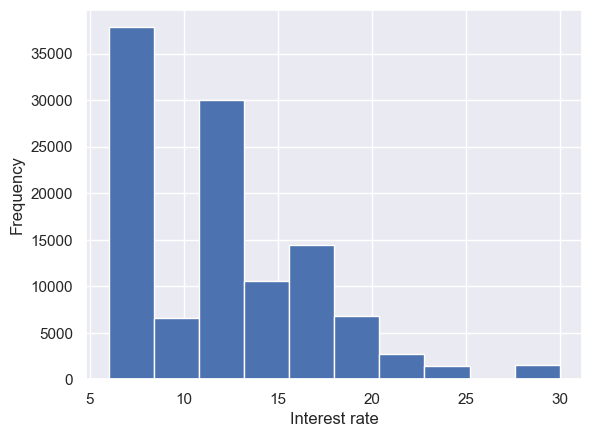

In [15]:
df.int_rate.plot(kind='hist')
plt.xlabel('Interest rate')
plt.show()

Interest rate sees some spikes around 5 to 10 percent. These are likely to be loans graded A and B, which are the most common grades on LendingClub. These loans are typically safer for the investor, but yield less potential ROI.

### Employment length

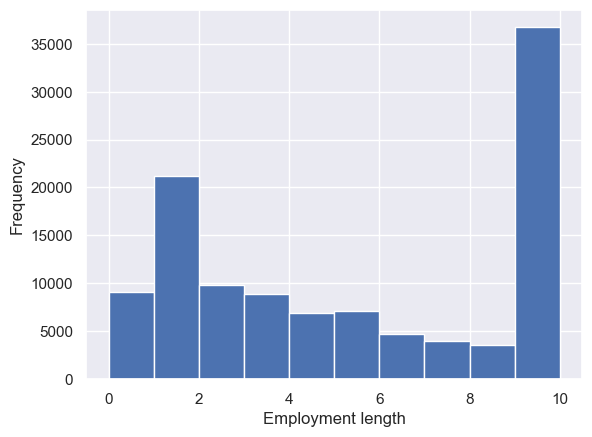

In [16]:
df.emp_length.plot(kind='hist')
plt.xlabel('Employment length')
plt.show()

Employment length is bimodal, with a small peak at 1 year and a sharp spike at 10 years. This shows varying backgrounds that LendingClub applicants come from, from those who have worked at one place for many years to those just starting their professional careers or changing jobs.

### Annual income

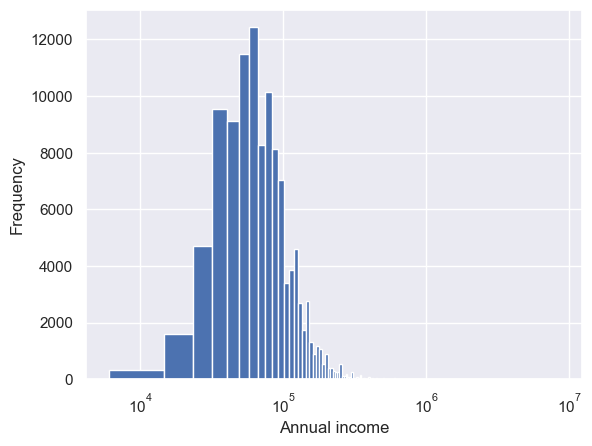

In [17]:
df.annual_inc.plot(kind='hist', bins=1000, logx=True)
plt.xscale('log')
plt.xlabel('Annual income')
plt.show()

Income is severely right skewed as seen before. We have values ranging from around \\$10,000 all the way up to \\$10 million. The log transformation is more bell-shaped.

### State

In [18]:
states = pd.DataFrame(df.addr_state.value_counts()).reset_index()
px.choropleth(states, color='addr_state', locations='index', locationmode='USA-states', scope='usa', 
                  color_continuous_scale=px.colors.carto.Burg, labels={'addr_state':'Applicants'})

The number of applications in a state corresponds pretty strongly to the state's population. As we might expect, the top states for LendingClub applicants are California, Texas, Florida, and New York. We have no applicants from Iowa.

# Explore Joint Attributes


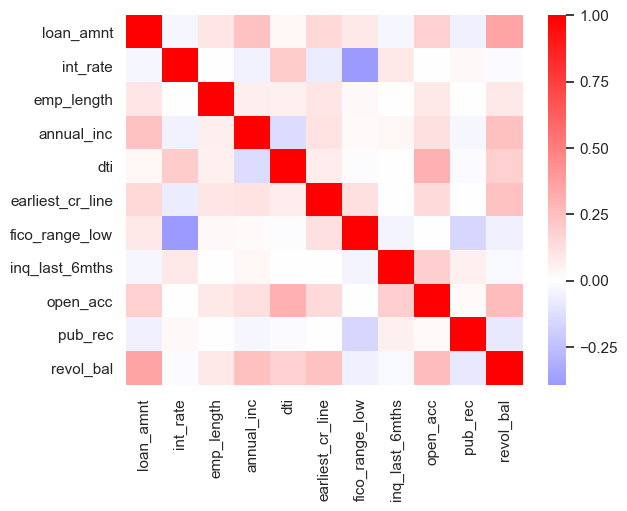

In [19]:
corr = df.corr()
sns.heatmap(corr, cmap='bwr', center=0)
plt.ylim(11,0)
plt.show()

Most correlations among our numerical variables are very low. The strongest positive correlation is between revolving balance and loan amount, and the strongest negative correlation is between FICO score and interest rate. We will look at these more closely next.

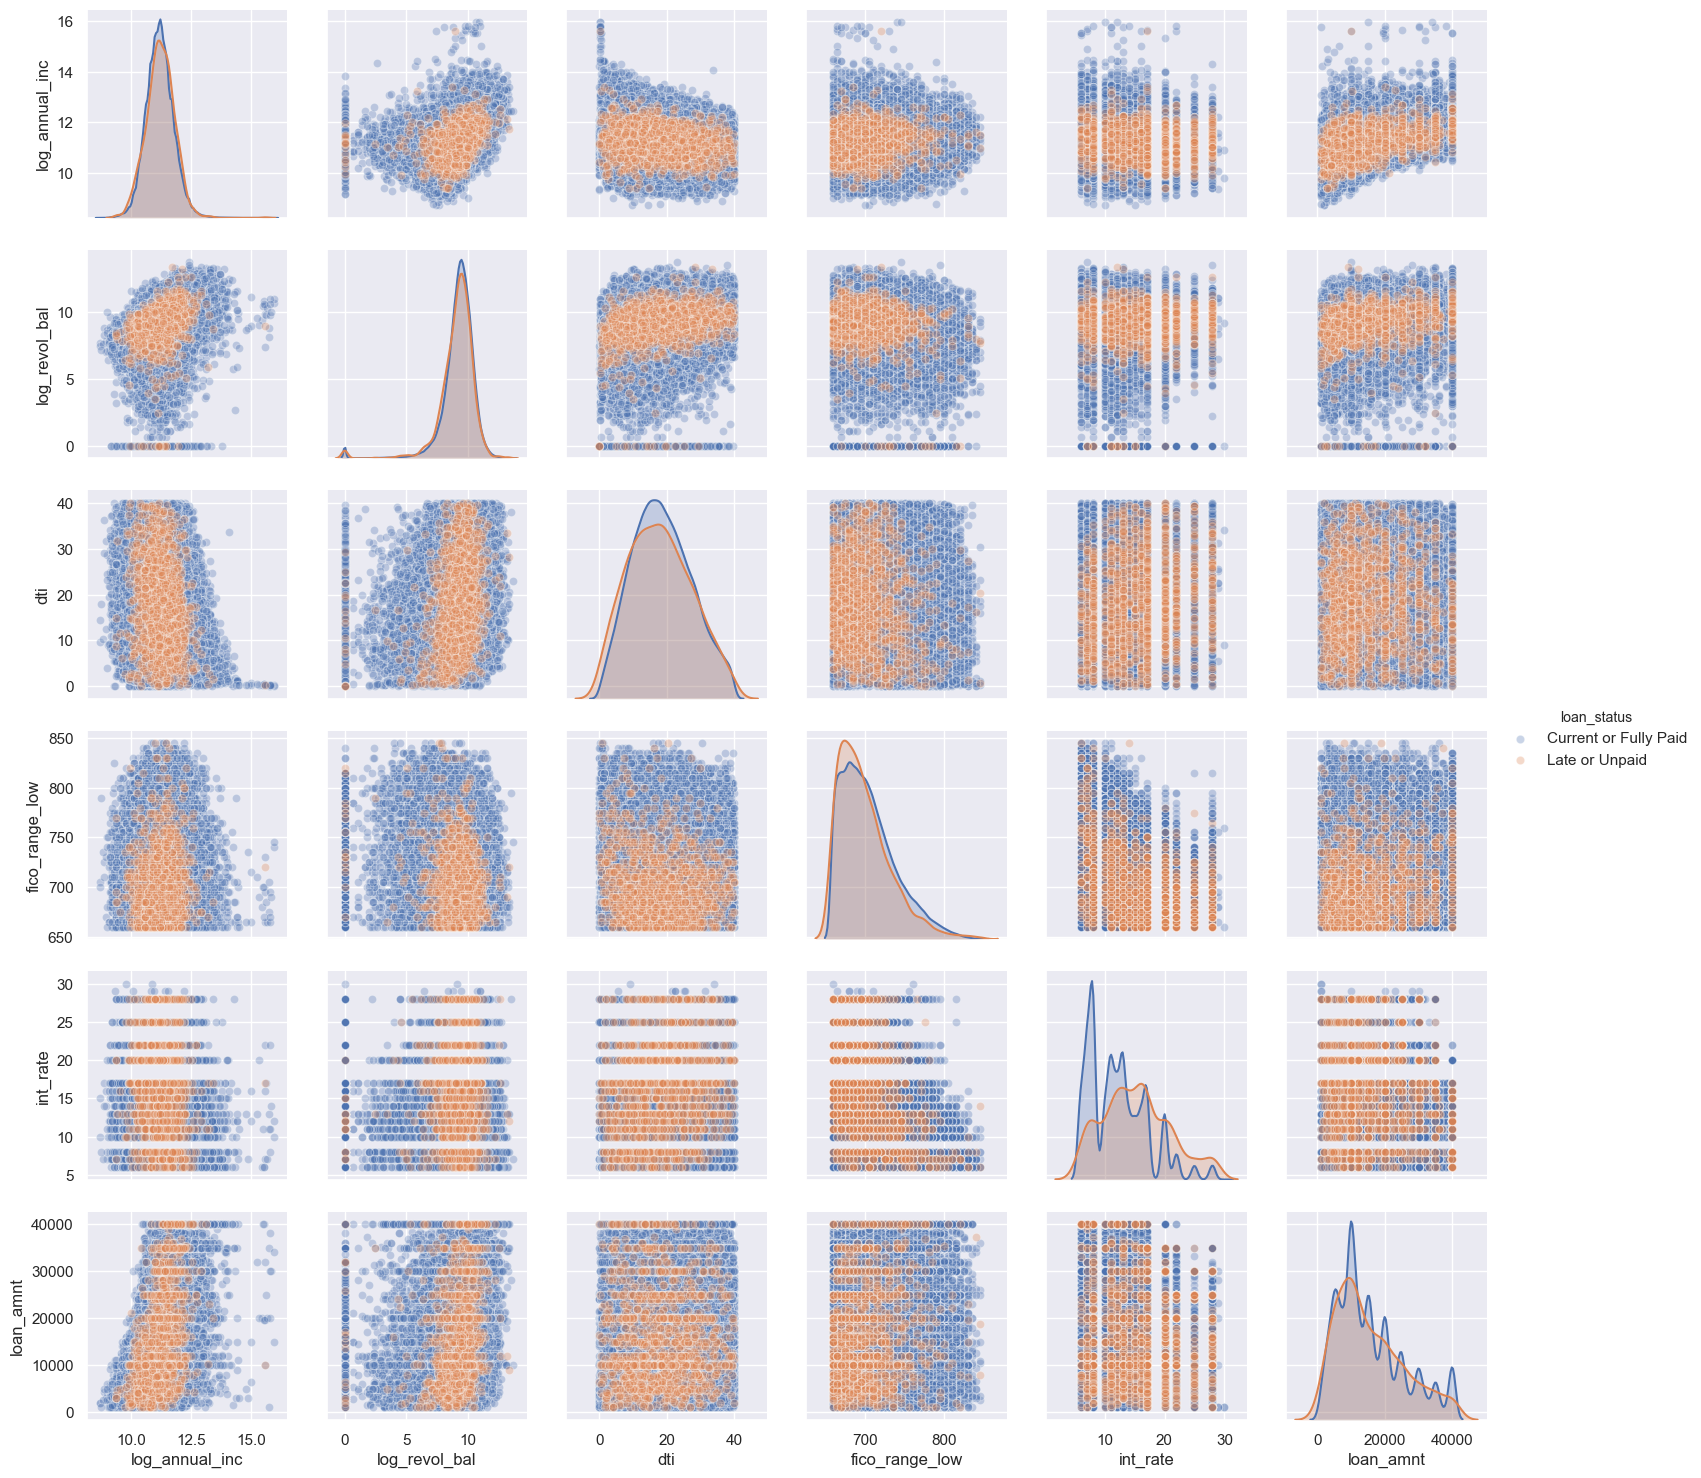

In [20]:
#Create log transformations of annual_inc and revol_bal for plotting
df['log_annual_inc'] = np.log(df.annual_inc)
#revol_bal has zeroes, so add 1 to avoid errors
df['log_revol_bal'] = np.log(df.revol_bal+1)
#Plot float variables in scatterplot matrix
sns.pairplot(df, vars=['log_annual_inc', 'log_revol_bal', 'dti', 'fico_range_low', 'int_rate', 'loan_amnt'], 
             hue='loan_status', plot_kws={'alpha':.3})
plt.show()

We can see a slight, nearly vertical, slope between log revolving balance and loan amount. Loan amount also appears to have a small linear relationship with log annual income. Interest rate and FICO score have somewhat of a negative relationship. There are applicants with the whole range of FICO scores at lower interest rates, but at higher interest rates the FICO scores have a narrower range, concentrated toward the lower side.

We have also plotted points that had a loan status of default in orange. We do not see a real separation here, but we can note that they do tend to be more concentrated toward the middle of each distribution.

### Loan amount by state

In [21]:
#Add default indicator for later
df['is_default'] = 0
df.loc[df['loan_status'] == 'Late or Unpaid', 'is_default'] = 1
#Pivot table for means of each variable by state
states_pivot = df.pivot_table(index='addr_state').reset_index()
px.choropleth(states_pivot, color='loan_amnt', locations='addr_state', locationmode='USA-states', scope='usa', 
                  color_continuous_scale=px.colors.carto.Burg, labels={'addr_state':'Applicants'})

The states with the highest average loan amounts are Alaska, Virginia, DC, New Jersey, and Maryland. The states with the lowest average loan amounts are Rhode Island, Nebraska, Vermont, Montana, and Mississippi.

### Interest rate vs. loan grade

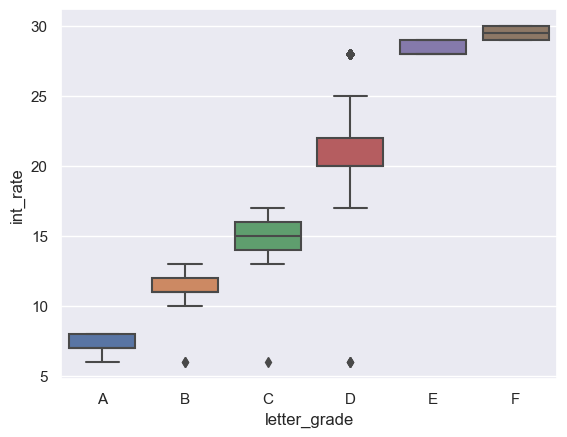

In [22]:
sns.boxplot(x='letter_grade', y='int_rate', data=df.sort_values('letter_grade'))
plt.show()

We know that LendingClub assigns higher interest rates to loans that it deems to be riskier. We can see here that there is very little overlap in interest rates between grades.

### Loan amount by purpose

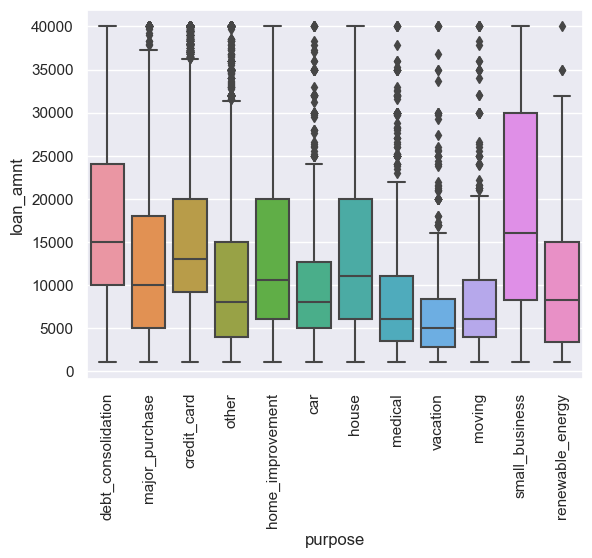

In [23]:
sns.boxplot(x='purpose', y='loan_amnt', data=df)
plt.xticks(rotation=90)
plt.show()

Interestingly, every purpose has loan amounts ranging all the way from the lowest value to the higest. The purpose with the highest median loan amount is small business, closely followed by debt consolidation. Applications for vacation loans have the lowest median loan amount, with moving and medical slightly higher.

# Explore Attributes and Class	


### Loan Status vs. Loan Amount

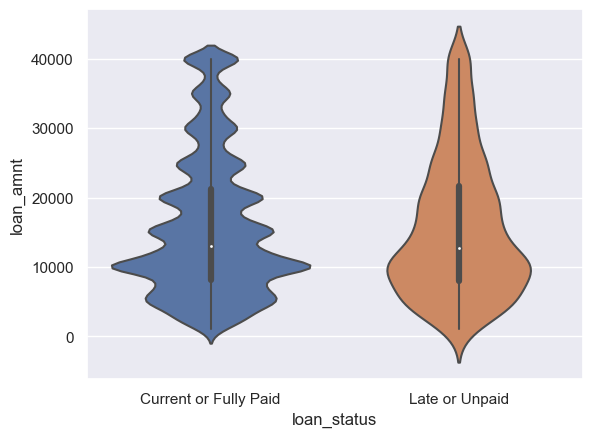

In [24]:
sns.violinplot(x='loan_status', y='loan_amnt', data=df)
plt.show()

There appears to be very little difference in distribution of loan amount between current and unpaid loans. Current loans appear to exhibit frequency spikes at every $5000, but it is hard to say if this is relevant.

### Loan Status vs. Annual Income

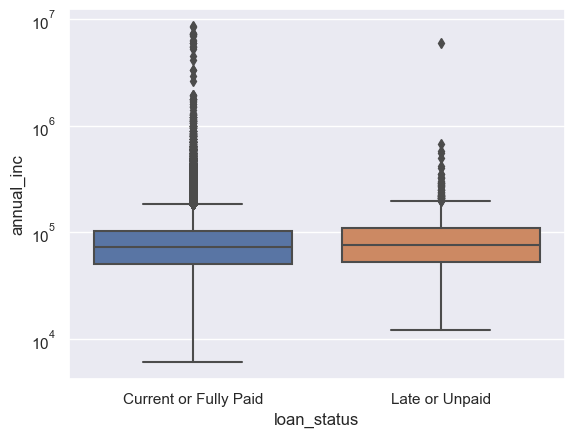

In [25]:
sns.boxplot(x='loan_status', y='annual_inc', data=df)
plt.yscale('log')
plt.show()

Annual income (shown here on a logarithmic scale) also appears to be very similar between current and late statuses. We expected borrowers with higher income to pay off their loans more often, but that does not appear to be the case.

### Loan Status vs. Sub Grade

In [26]:
px.histogram(df, x='loan_status', color='letter_grade', barnorm='fraction', 
                 labels={"loan_status":"Loan Status", "letter_grade": "Sub Grade"}, 
                 title="Loan Status vs. Sub Grade", width=800)

Higher grade loans are more likely to be current or fully paid than lower grade loans. This shows that Lending Club's grading scheme is largely successful, and our goal will be to look for marginal improvements to try to make more money than just investing based on the grade.

### Loan Status by State

In [27]:
px.choropleth(states_pivot, color='is_default', locations='addr_state', locationmode='USA-states', scope='usa', 
                  color_continuous_scale=px.colors.carto.Burg, labels={'is_default':'Default rate'})

Delaware, Utah, Nebraska, Missouri, and Alabama have the highest percentage of late or unpaid loans. The lowest default rates belong to Wyoming, Rhode Island, Hawaii, Maine, and New Hampshire.

### Loan Status vs. Debt-to-income Ratio

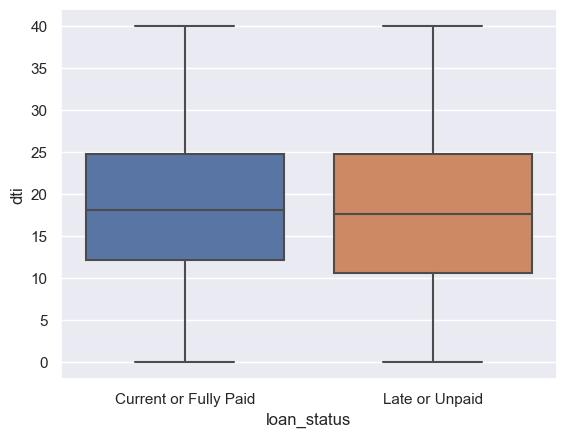

In [28]:
sns.boxplot(x='loan_status', y='dti', data=df)
plt.show()

Surprisingly, debt-to-income ratio does not seem to affect whether a loan becomes current or unpaid. Borrowers with current loans actually have a slightly higher DTI ratio.

# New Features

The biggest thing that is missing from this data is more demographic information. It is likely that we could more accurately predict when a loan would default if we had information on the age of applicants, their education level, and their criminal records, for example. As this is banking data, it is likely that this sort of data is not collected on purpose, as not to discriminate.

It may also be helpful to use more of the data available, as LendingClub has records at the same level of detail for a number of years. While these aren't features, more data is generally useful.

Additionally, pulling in more traditional banking data to our model may help us generalize better. Even if this isn't peer to peer lending, the pressures on consumers should be similar, which would drive default rates about the same. It would take some evaluation, but default rates may also be location dependent- Traditional banking data would help us see those trends, if they do exist.

# Exceptional Work

## Dimensionality Reduction

We opted to employ some dimensionality reduction on the data by performing principal components analysis. The charts below detail these efforts. Scikit-learn was used to standardize the variables and do the PCA, while seaborn was used to plot the results and scree plot. Overall, it doesn't seem that PCA would help much with this data, as is evidenced by the first two graphs. There is not a substantial divide between the two classes that we wish to predict. PC2 vs. PC3 shows a divide, but with no relation to the predicted classes.

If we did opt to use the PCA for fitting a model, it seems that 2 principal components would be what we would want, based on the scree plot shown third.

In [29]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

#Drop categorical variables
df2 = df.loc[:,df.dtypes!=object]

#Drop columns that were created for visualization
df2.drop(columns=['log_annual_inc','log_revol_bal','is_default'], inplace=True)

scaler = StandardScaler()
df_dummy = pd.get_dummies(df2, drop_first=True)
df_scaled = scaler.fit_transform(df_dummy)

pca = PCA(n_components=11)
df_PCA = pca.fit_transform(df_scaled)
df_PCA = pd.DataFrame(df_PCA)
df_PCA['loan_status'] = df['loan_status']

F:\brady\Anaconda3\envs\ML7331\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



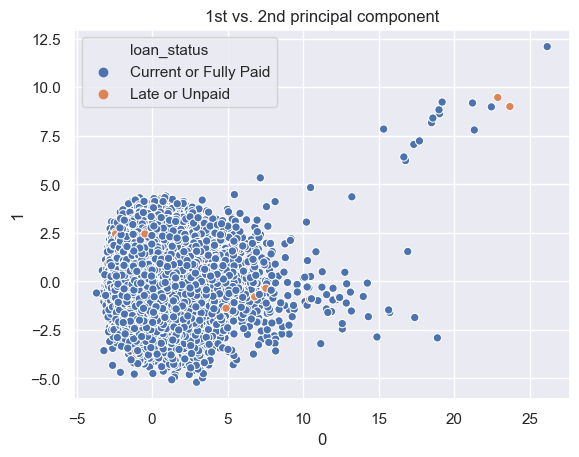

In [30]:
sns.scatterplot(data = df_PCA, x = 0, y = 1, hue = 'loan_status')
plt.title('1st vs. 2nd principal component')
plt.show()

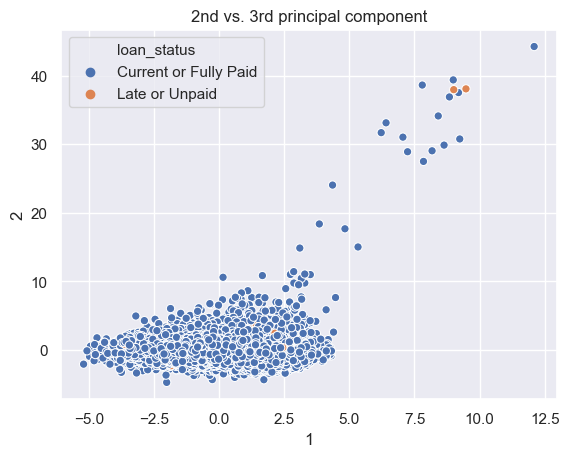

In [31]:
sns.scatterplot(data = df_PCA, x = 1, y = 2, hue = 'loan_status')
plt.title('2nd vs. 3rd principal component')
plt.show()

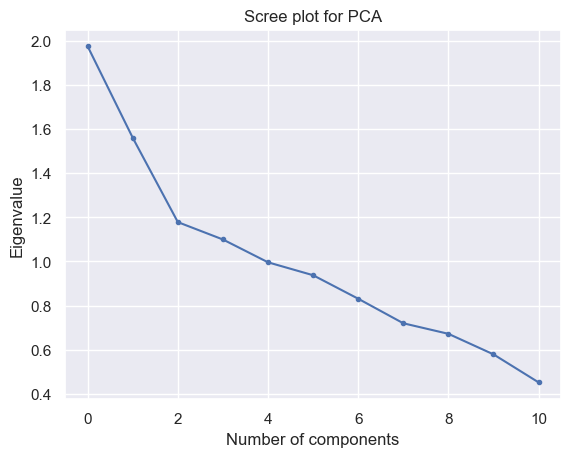

In [32]:
plt.plot(pca.explained_variance_, 'bo-', markersize='3')
plt.title('Scree plot for PCA')
plt.xlabel('Number of components')
plt.ylabel('Eigenvalue')
plt.show()

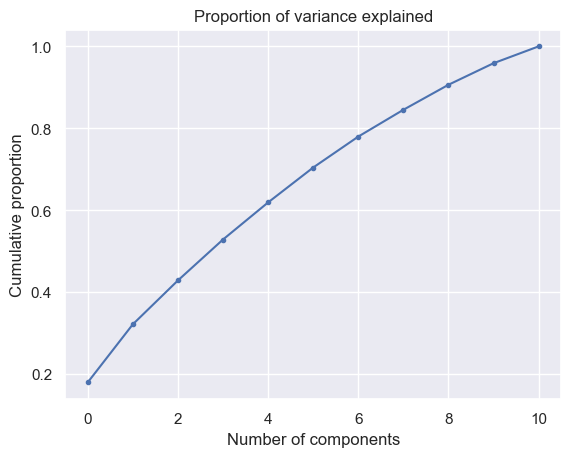

In [33]:
plt.plot(pca.explained_variance_ratio_.cumsum(), 'bo-', markersize='3')
plt.title('Proportion of variance explained')
plt.xlabel('Number of components')
plt.ylabel('Cumulative proportion')
plt.show()